In [ ]:
import matplotlib as mpl
import pickle
import json
from pathlib import Path
import torchinfo
import torch
import time
import einops
import h5py
import sys
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
device = torch.device("cpu")
mpl.rc('text', usetex=True)
mpl.rc('font', family='serif')

sys.path.append('../')
from neuralnetwork.autoencoder import CAE

sys.path.insert(0, '../../EchoStateNetwork/') # you need to get the git repo https://github.com/MagriLab/EchoStateNetwork
from esn.esn import ESN
from esn.validation import validate
from esn.utils import errors, scalers

In [2]:
cae_path = Path('../weights/fluent-sweep-2/')
with open(cae_path/'ks.json') as f:
    ks_data = json.load(f)
    print(ks_data)

with open(cae_path /'encoded_ks.npy', 'rb') as f:
    U_encoded = np.load(f)

{'upsample': 4, 'L': 22, 'N_data': 400000, 'N_trans': 1000, 'dt': 0.005, 'Nx': 512, 'train_ratio': 0.8, 'valid_ratio': 0.1, 'batchsize': 128, 'normtype': 'max', 'lyap': 0.08}


In [3]:
U_esn = generate_esn_noise_data(U_encoded, 1, sigma_n=1e-3)
u_encoded_train, u_encoded_valid, u_encoded_test = train_valid_test_split(U_esn, ks_data)

In [4]:
total_samples, dim = u_encoded_train.shape
N_washout = 200
train_size = min(len(u_encoded_train)-N_washout-101, 100000)#-1001
val_size = min(len(u_encoded_valid)-101-N_washout, 20001)
test_N_washout = 100
# Split the data into different datasets
U_washout = u_encoded_train[:N_washout, ...]
U_train_input = u_encoded_train[N_washout:N_washout+train_size-1, ...]
U_train_label = u_encoded_train[N_washout + 1:N_washout+train_size, ...]
U_val_input = u_encoded_valid[:val_size-1, ...]
U_val_label = u_encoded_valid[1:val_size, ...]
U_test_washout = u_encoded_test[:test_N_washout, ...]
U_test = u_encoded_test[N_washout:, ...]
# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape, U_train_label.shape}")
print(f"U_val shape: {U_val_input.shape, U_val_label.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: ((99999, 8), (99999, 8))
U_val shape: ((20000, 8), (20000, 8))
U_test shape: (139551, 8)


In [5]:
#  specify which hyperparameters to search, e.g., spectral_radius, input_scaling, leak_factor
hyperparameter_dict = {
    'spectral_radius': [0.1, 1.0, 'uniform'],
    'input_scaling': [0.01, 10.0, 'log10'],
    'tikhonov': [1e-12, 1e-3, 'log10'],
    # 'leak_factor': [0.1, 1.0, 'uniform']  # Uncomment if needed
}
grid_range = []
for i, parameter in enumerate(hyperparameter_dict.keys()):
    scaler = getattr(scalers, hyperparameter_dict[parameter][-1])
    grid_range.append(scaler(hyperparameter_dict[parameter][:2]))

# compute normalization factor (range component-wise)
U_data = U_esn[:N_washout+train_size, :dim].copy()
m = U_data.min(axis=0)
M = U_data.max(axis=0)
norm = M-m
u_mean = U_data.mean(axis=0)

N_val = 1000  # number of validation steps

# fixed properties of the ESN
ESN_dict = {'reservoir_size': 1000,
        'dimension': dim,
        'reservoir_connectivity': 10,
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]),
        'input_bias': np.array([1]),
        # np.array([np.mean(np.abs((U_data-u_mean)/norm))]*2),
        'output_bias':  np.array([1]),
        'reservoir_weights_mode': "erdos_renyi1",
        # 'tikhonov': 1e-10,
        'input_normalization': [u_mean, norm],
        # 'input_weights_mode': 'dense',
        'input_seeds':[0, 1, 2],
        'reservoir_seeds':[3, 4]
    }


min_dict = validate(
    grid_range=grid_range,
    param_names=[key for key in hyperparameter_dict.keys()],
    param_scales=[values[-1] for values in hyperparameter_dict.values()],
    n_calls=20,  # number of total trials
    n_initial_points=10,  # number of initial trials before bayesian optimization
    ESN_dict=ESN_dict,
    U_washout_train=U_washout,
    n_realisations=1,  # number of random ESN realisations
    U_train=U_train_input,
    Y_train=U_train_label,
    U_val=U_val_input,
    Y_val=U_val_label,
    n_folds=5,  # number of folds, i.e., validation time series that start from random time instances
    N_washout_steps=N_washout,
    N_val_steps=N_val,
    random_seed=10,  # random seed for the bayesian optimization
    error_measure=errors.rel_L2)  # error measure to optimize over

Input to run_gp:([Real(low=0.1, high=1.0, prior='uniform', transform='identity'), Real(low=-2.0, high=1.0, prior='uniform', transform='identity'), Integer(low=-12.0, high=-3.0, prior='uniform', transform='identity')], 20, 10, 10)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6335601564025166
input_scaling 3.41033659841376
tikhonov 9.999999999999999e-05


Val regime: 0
Fold: 0 , fold error:  1.0237598928011413
Fold: 1 , fold error:  1.0868525753044231
Fold: 2 , fold error:  0.9370912135092162
Fold: 3 , fold error:  1.0681061774563916
Fold: 4 , fold error:  1.0405655755682366
Val regime error: 1.0312750869278817
Realisation error: 1.0312750869278817


Run 1 error: 1.0312750869278817


--NEW RUN-- 2
Realisation: 0
spectral_radius 0.8625265649057131
input_scaling 0.7424908231815013
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  0.8806665350891084
Fold: 1 , fold error:  1.0194895636588375
Fold: 2 , fold error:  0.7056564283549721
Fold: 3 , fold error:  0.972663894544

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.67618e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.8852858605747275
Fold: 1 , fold error:  0.867625494698001
Fold: 2 , fold error:  0.8522867449254389
Fold: 3 , fold error:  0.9106346463130912
Fold: 4 , fold error:  0.8158081349941587
Val regime error: 0.8663281763010835
Realisation error: 0.8663281763010835


Run 3 error: 0.8663281763010835


--NEW RUN-- 4
Realisation: 0
spectral_radius 0.529898605589215
input_scaling 2.732160361977424
tikhonov 1e-08


Val regime: 0
Fold: 0 , fold error:  1.1730557196457334
Fold: 1 , fold error:  0.6793633599313663
Fold: 2 , fold error:  1.1216511069189703
Fold: 3 , fold error:  1.1490917377348009
Fold: 4 , fold error:  1.1476108701864933
Val regime error: 1.0541545588834729
Realisation error: 1.0541545588834729


Run 4 error: 1.0541545588834729


--NEW RUN-- 5
Realisation: 0
spectral_radius 0.4535063164907469
input_scaling 3.2228217847874103
tikhonov 9.999999999999999e-10


Val regime: 0
Fold: 0 , fold error:  0.9127826118012003
Fold: 1 , fold error:  1.11354080

/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.62884e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.104226471047944
Fold: 1 , fold error:  0.9439396638111208
Fold: 2 , fold error:  0.9921597066696374
Fold: 3 , fold error:  0.8401622800057148
Fold: 4 , fold error:  0.9240698216658555
Val regime error: 0.9609115886400545
Realisation error: 0.9609115886400545


Run 13 error: 0.9609115886400545


--NEW RUN-- 14
Realisation: 0
spectral_radius 0.15324967459455752
input_scaling 0.01598037622354782
tikhonov 1e-12




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.83041e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.958810487629364
Fold: 1 , fold error:  0.9471570533970073
Fold: 2 , fold error:  43291.572514798725
Fold: 3 , fold error:  0.9578783079364229
Fold: 4 , fold error:  56000.819649246354
Val regime error: 19859.051201978808
Realisation error: 19859.051201978808


Run 14 error: 19859.051201978808


--NEW RUN-- 15
Realisation: 0
spectral_radius 0.3709738388013215
input_scaling 0.012921164581596771
tikhonov 9.999999999999999e-11




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.17117e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.8710345530519233
Fold: 1 , fold error:  0.8646208501824328
Fold: 2 , fold error:  0.889426105446514
Fold: 3 , fold error:  0.9052778467619607
Fold: 4 , fold error:  0.8559045860529226
Val regime error: 0.8772527882991505
Realisation error: 0.8772527882991505


Run 15 error: 0.8772527882991505


--NEW RUN-- 16
Realisation: 0
spectral_radius 0.20449793539875608
input_scaling 0.017249566499364197
tikhonov 1e-12




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.70176e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.022925449889229
Fold: 1 , fold error:  1.0337756124119275
Fold: 2 , fold error:  1.168111157234984
Fold: 3 , fold error:  1.1058174806524064
Fold: 4 , fold error:  1.1346426925948507
Val regime error: 1.0930544785566796
Realisation error: 1.0930544785566796


Run 16 error: 1.0930544785566796


--NEW RUN-- 17
Realisation: 0
spectral_radius 0.7155423790979519
input_scaling 0.15318761683424104
tikhonov 1e-06


Val regime: 0
Fold: 0 , fold error:  1.1538105737424746
Fold: 1 , fold error:  1.366946820271288
Fold: 2 , fold error:  1.341188735415803
Fold: 3 , fold error:  1.1209521604182133
Fold: 4 , fold error:  1.166160878270005
Val regime error: 1.2298118336235566
Realisation error: 1.2298118336235566


Run 17 error: 1.2298118336235566


--NEW RUN-- 18
Realisation: 0
spectral_radius 0.4974649163572141
input_scaling 0.6661154051215268
tikhonov 9.999999999999999e-10




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=4.58071e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.9196129346574807
Fold: 1 , fold error:  0.9803000790312865
Fold: 2 , fold error:  1.0996903670315215
Fold: 3 , fold error:  1.0707842534267673
Fold: 4 , fold error:  0.9662653649762356
Val regime error: 1.0073305998246584
Realisation error: 1.0073305998246584


Run 18 error: 1.0073305998246584


--NEW RUN-- 19
Realisation: 0
spectral_radius 0.1990744101759147
input_scaling 0.6313606739939809
tikhonov 9.999999999999999e-11




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.48428e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  1.0328007814797195
Fold: 1 , fold error:  0.8429844868727915
Fold: 2 , fold error:  1.0824006450868247
Fold: 3 , fold error:  1.1277594396328732
Fold: 4 , fold error:  1.076179329721269
Val regime error: 1.0324249365586955
Realisation error: 1.0324249365586955


Run 19 error: 1.0324249365586955


--NEW RUN-- 20
Realisation: 0
spectral_radius 0.416815385433254
input_scaling 0.9081982261360908
tikhonov 1e-11




/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.29674e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Val regime: 0
Fold: 0 , fold error:  0.7158139072704482
Fold: 1 , fold error:  0.7037120859148867
Fold: 2 , fold error:  0.9248829336186264
Fold: 3 , fold error:  1.132773515768058
Fold: 4 , fold error:  0.8687582991531416
Val regime error: 0.8691881483450322
Realisation error: 0.8691881483450322


Run 20 error: 0.8691881483450322


{'f': array([0.85951055, 0.86632818, 0.86918815, 0.87725279, 0.88264318]), 'spectral_radius': array([0.11347225, 0.36778115, 0.41681539, 0.37097384, 0.78275406]), 'input_scaling': array([0.01685576, 0.01479582, 0.90819823, 0.01292116, 0.0207837 ]), 'tikhonov': array([1.e-09, 1.e-10, 1.e-11, 1.e-10, 1.e-08])}


In [6]:
esn_loaded_dict = dict(min_dict, **ESN_dict)

In [7]:
with open(cae_path / 'esn_best_dict.pkl', 'rb') as f:
    esn_loaded_dict = pickle.load(f)

print(f"Dictionary loaded in {esn_loaded_dict}")
i=0
my_ESN = ESN(reservoir_size=esn_loaded_dict["reservoir_size"],
                dimension=esn_loaded_dict["dimension"],
                reservoir_connectivity=esn_loaded_dict["reservoir_connectivity"],
                spectral_radius=esn_loaded_dict['spectral_radius'][i],
                input_scaling=esn_loaded_dict['input_scaling'][i],
                tikhonov=esn_loaded_dict['tikhonov'][i],
                input_bias=esn_loaded_dict["input_bias"],
                output_bias=esn_loaded_dict["output_bias"],
                reservoir_weights_mode=esn_loaded_dict['reservoir_weights_mode'],
                input_normalization=esn_loaded_dict['input_normalization'],
                # input_weights_mode=esn_loaded_dict['input_weights_mode'],
                #   leak_factor =min_dict['leak_factor'][i],
                input_seeds=esn_loaded_dict["input_seeds"],
                reservoir_seeds=esn_loaded_dict["reservoir_seeds"], verbose=False)
my_ESN.train(U_washout, U_train_input, U_train_label)

Dictionary loaded in {'reservoir_size': 5000, 'dimension': 8, 'reservoir_connectivity': 10, 'input_bias': array([1]), 'output_bias': array([1]), 'reservoir_weights_mode': 'erdos_renyi1', 'input_normalization': [array([ 0.04632736, -0.0202649 , -0.08058597, -0.04703639, -0.14330693,
       -0.03961901, -0.03926516, -0.14617444]), array([0.78222102, 0.80043198, 0.84137316, 0.76709582, 0.69758855,
       0.7997398 , 0.728731  , 0.70858355])], 'input_weights_mode': 'dense', 'input_seeds': [0, 1, 2], 'reservoir_seeds': [3, 4], 'f': array([0.36003981, 0.40722199, 0.42022049, 0.45035164, 0.4855863 ]), 'spectral_radius': array([0.80881943, 0.82161872, 0.79331233, 0.79900527, 0.67501252]), 'input_scaling': array([0.0946024 , 0.09639518, 0.09498936, 0.09443689, 0.09481721]), 'tikhonov': array([1.e-10, 1.e-10, 1.e-10, 1.e-10, 1.e-10])}


/home/eo821/miniconda3/envs/cae-esn-tf/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.16252e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [8]:
cae_model = CAE(8)
cae_model.load_state_dict(torch.load(cae_path/"best_model.pth", map_location=device))
cae_model = cae_model.to(device)

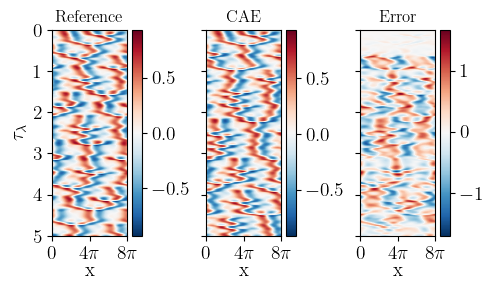

In [10]:

# Define constants
N_lyap = int(1/ks_data["lyap"]/(ks_data["dt"]*ks_data["upsample"]))
N_plot = 5*N_lyap
fs = 14
cmap = 'RdBu_r'

# Calculate domain length
domain_length = 20 * np.pi

# Create subplots
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(5,3), sharey=True)  # Changed ncols to 1

N_start = 200 
reservoir, prediction = my_ESN.closed_loop_with_washout(u_encoded_test[N_start:N_start+N_washout, :dim], 15000)
snapshot_decoded = cae_model.decoder(torch.from_numpy(prediction).float().to(device)).numpy(force=True)
snapshot = cae_model.decoder(torch.from_numpy( u_encoded_test[N_start+N_washout:N_start+N_washout+15000, :dim]).float().to(device)).numpy(force=True)


# Extract data
data1 = snapshot[:N_plot, 0, :] 
data2 = snapshot_decoded[:N_plot, 0, :] 
data3 = data1 - data2

lyapunov_time = ks_data["lyap"] * np.arange(0, 10000, (ks_data["dt"]*ks_data["upsample"]))
# Adjust subplot spacing
plt.subplots_adjust(wspace=-0.05)  #
# Plot data
for i, data in enumerate([data1, data2, data3]):
    axes = axs[i]
    im = axes.imshow(data, aspect='auto', cmap=cmap,
                     extent=[0, 2 * 4 * np.pi, int(lyapunov_time[N_plot]), lyapunov_time[0]])


    axes.set_xlabel('x', fontsize=fs, rotation=0, labelpad=0, y=0.46)
     # Set y-tick labels and font size
    axes.set_yticks(axes.get_yticks())  # Ensure yticks are set first
    axes.set_yticklabels([f'{int(tick)}' for tick in axes.get_yticks()], fontsize=fs)

    axes.yaxis.tick_left()
    axes.set_xticks(np.arange(0, 8 * np.pi + 0.01, step=(1 * 4 * np.pi)), ['0', r'$4\pi$', r'8$\pi$'],
                    fontsize=fs)
    for tick_label in axes.get_xticklabels():
        tick_label.set_ha('center')
        tick_label.set_x(-0.05)

    cbar = fig.colorbar(im, ax=axes)
    cbar.ax.tick_params(labelsize=fs)

axs[0].set_ylabel(r'$\tau_{\lambda}$', fontsize=fs)
axs[0].set_title("Reference")
axs[1].set_title("CAE")
axs[2].set_title("Error")
# Show or save plot
plt.tight_layout()
# plt.savefig("../images/cae-esn.png", dpi=100)
